In [3]:
import time

import mujoco
import numpy as np

In [4]:
# PID-регулятор:
class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.prev_error = 0
        self.integral = 0

    def control(self, target, current, current_velocity, dt):
        error = target - current
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        return self.kp * error + self.ki * self.integral - self.kd * derivative

In [5]:
model_path = r"model1.xml"
model = mujoco.MjModel.from_xml_path(model_path)

In [6]:
def inverse_kinematics(x, y, z, L1, L2, L3) -> tuple[float, float, float]:
    '''Решение обратной задачи кинематики
    
    параметры: конечные координаты x, y, z
               длины звеньев L1, L2, L3 
    
    на выход: целевые углы
    '''
    phi1 = np.arctan2(y, x)
    
    #Проекция на плоскость манипулятора:
    AD = np.sqrt(x**2 + y**2)
    CD = z - L1
    AC = np.sqrt(AD**2 + CD**2)
    
    #Проверка рабочей зоны:
    if AC > (L2 + L3):
        raise ValueError('Точка недостижима, вне рабочего пространства')
    
    #phi_2 и phi_3: 
    angle_CAD = np.arctan2(CD, AD)
    angle_BAC = np.arccos((AC**2 + L2**2 - L3**2) / (2 * AC * L2))
    phi2 = np.pi / 2 - angle_CAD - angle_BAC
    
    angle_CBA = np.arccos((L2**2 + L3**2 - AC**2) / (2 * L2 * L3))
    phi3 = np.pi - angle_CBA
    
    return phi1, phi2, phi3

In [7]:
def motion_control(model, data):
    global RUN, targets, target_index, dt, in_goal, time_activation
    counter = 0
    for i in range(len(pid_controllers)):
        current_position = data.qpos[i]
        current_velocity = data.qvel[i]
        control_signal = pid_controllers[i].control(
            target=targets[target_index][i],
            current=current_position,
            current_velocity=current_velocity,
            dt=dt,
        )
        
        data.ctrl[i] = control_signal

        err_data = abs(targets[target_index][i] - current_position)
        # print(f'Ошибка по {i}  {err_data}')
        if err_data < 0.2:
            counter += 1
    if counter == 3:
        if target_index < len(targets)-1:
            if time_activation is None:
                time_activation = time.time()
            else:
                if time.time() - time_activation > 2:
                    target_index += 1
                    time_activation = None
        else:
            if time_activation is None:
                time_activation = time.time()
            else:
                if time.time() - time_activation > 2:
                    RUN = False


In [8]:
data = mujoco.MjData(model)
mujoco.set_mjcb_control(motion_control)

pid_controllers = [
    PIDController(kp=6, ki=0.25, kd=0),
    PIDController(kp=12, ki=0.8, kd=0),
    PIDController(kp=6, ki=0.28, kd=0),
]


target_box = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, "target_box")
viewer = mujoco_viewer.MujocoViewer(model, data)

l = 0.2
target_index = 0
targets = [[0.35, 0, 0.05], 
           [0.35, 0, 0.3], 
           [-0.35, 0, 0.3], 
           [-0.35, 0, 0.05]]
for i in range(len(targets)):
    targets[i] = inverse_kinematics(*targets[i], l, l, l)
    
time_activation = None 
x, y, z = [], [], []
control_data = []
time_data = []
RUN = True
while RUN:
    dt = model.opt.timestep
    # print(f'Целевые: {targets[target_index]} | Текущие: {[round(d, 3) for d in data.qpos]}')
    # print(data.ctrl)
    x.append(data.qpos[0])
    y.append(data.qpos[1])
    z.append(data.qpos[2])
    mujoco.mj_step(model, data)
    viewer.render()

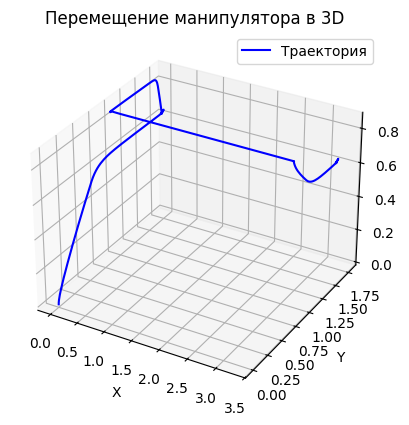

In [10]:
import matplotlib.pyplot as plt

x = np.array(x)
y = np.array(y)
z = np.array(z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, label='Траектория', color='blue')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Перемещение манипулятора в 3D')
ax.legend()

plt.show()